In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from datasets import load_data
from model import model_summary
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('S8/util.py')
from util import test, train, plot_acc_loss
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu')
print(device)

c:\Users\Aai\anaconda3\envs\pytorch\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


cuda


In [2]:
train_loader ,  test_loader  = load_data()


Files already downloaded and verified
Files already downloaded and verified


In [10]:
class S8_Model_BN(nn.Module):
    def __init__(self):
        super(S8_Model_BN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=48, kernel_size=7, padding=3, bias=False), 
            nn.GroupNorm(4,48),
            nn.ReLU(),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3,bias=False),  
            nn.GroupNorm(4,64),
            nn.ReLU(),
            
        )
        self.conv1x1_3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1),  
            nn.GroupNorm(4,32),
            nn.ReLU(),
        )
        self.pool_1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=3, bias=False),  
            nn.GroupNorm(4,8),
            nn.ReLU(),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3,bias=False),  
            nn.GroupNorm(4,8),
            nn.ReLU(),
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3,bias=False),  
            nn.GroupNorm(4,8),
            nn.ReLU(),
        )
        self.conv1x1_7 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=1), 
            nn.GroupNorm(4,16),
            nn.ReLU(),
        )
        self.pool_2 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3,bias=False),  
            nn.GroupNorm(4,16),
            nn.ReLU(),
        )
        self.conv9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=1,bias=False),  
            nn.GroupNorm(4,64),
            nn.ReLU(),
        )
        self.conv10 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1,bias=False),  
            nn.GroupNorm(4,64),
        )
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.conv1x1_11 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=1))


        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv1x1_3(x)
        x = self.pool_1(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv1x1_7(x)
        x = self.pool_2(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.gap(x)
        x = self.conv1x1_11(x)
        x = x.view(x.size(0), -1)  
        x = F.log_softmax(x, dim=1)
        return x



In [11]:
model = S8_Model_BN().to(device)
model_summary(model,input_size= (3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 28, 28]           7,056
         GroupNorm-2           [-1, 48, 28, 28]              96
              ReLU-3           [-1, 48, 28, 28]               0
            Conv2d-4           [-1, 64, 26, 26]          27,648
         GroupNorm-5           [-1, 64, 26, 26]             128
              ReLU-6           [-1, 64, 26, 26]               0
            Conv2d-7           [-1, 32, 26, 26]           2,080
         GroupNorm-8           [-1, 32, 26, 26]              64
              ReLU-9           [-1, 32, 26, 26]               0
        MaxPool2d-10           [-1, 32, 13, 13]               0
           Conv2d-11            [-1, 8, 11, 11]           2,304
        GroupNorm-12            [-1, 8, 11, 11]              16
             ReLU-13            [-1, 8, 11, 11]               0
           Conv2d-14              [-1, 

In [12]:

optimizer_sgd = optim.SGD(model.parameters(), lr=0.01,momentum=0.9,dampening=0,weight_decay=0,nesterov=False)
scheduler = optim.lr_scheduler.StepLR(optimizer_sgd, step_size=5, gamma=0.1, verbose=True)
criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer_sgd,criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()




Epoch 1


Train: Loss=1.6747 Batch_id=781 Accuracy=21.98: 100%|██████████| 782/782 [00:22<00:00, 35.25it/s]


Test set: Average loss: 0.0295, Accuracy: 3003/10000 (30.03%)

Epoch 2


Train: Loss=1.8547 Batch_id=781 Accuracy=36.32: 100%|██████████| 782/782 [00:19<00:00, 40.42it/s]


Test set: Average loss: 0.0302, Accuracy: 3149/10000 (31.49%)

Epoch 3


Train: Loss=1.5174 Batch_id=781 Accuracy=39.90: 100%|██████████| 782/782 [00:19<00:00, 41.08it/s]


Test set: Average loss: 0.0253, Accuracy: 4082/10000 (40.82%)

Epoch 4


Train: Loss=1.8753 Batch_id=781 Accuracy=42.27: 100%|██████████| 782/782 [00:19<00:00, 40.86it/s]


Test set: Average loss: 0.0244, Accuracy: 4280/10000 (42.80%)

Epoch 5


Train: Loss=1.4396 Batch_id=781 Accuracy=43.99: 100%|██████████| 782/782 [00:19<00:00, 41.00it/s]


Test set: Average loss: 0.0238, Accuracy: 4493/10000 (44.93%)

Epoch 6


Train: Loss=1.3352 Batch_id=781 Accuracy=48.21: 100%|██████████| 782/782 [00:19<00:00, 40.84it/s]


Test set: Average loss: 0.0227, Accuracy: 4684/10000 (46.84%)

Epoch 7


Train: Loss=1.4507 Batch_id=781 Accuracy=49.08: 100%|██████████| 782/782 [00:19<00:00, 41.08it/s]


Test set: Average loss: 0.0226, Accuracy: 4741/10000 (47.41%)

Epoch 8


Train: Loss=1.2971 Batch_id=781 Accuracy=49.73: 100%|██████████| 782/782 [00:18<00:00, 41.16it/s]


Test set: Average loss: 0.0228, Accuracy: 4677/10000 (46.77%)

Epoch 9


Train: Loss=1.4725 Batch_id=781 Accuracy=50.05: 100%|██████████| 782/782 [00:19<00:00, 40.99it/s]


Test set: Average loss: 0.0225, Accuracy: 4758/10000 (47.58%)

Epoch 10


Train: Loss=1.4091 Batch_id=781 Accuracy=50.54: 100%|██████████| 782/782 [00:19<00:00, 40.96it/s]


Test set: Average loss: 0.0226, Accuracy: 4697/10000 (46.97%)

Epoch 11


Train: Loss=1.5324 Batch_id=781 Accuracy=51.37: 100%|██████████| 782/782 [00:19<00:00, 40.96it/s]


Test set: Average loss: 0.0223, Accuracy: 4809/10000 (48.09%)

Epoch 12


Train: Loss=1.3916 Batch_id=781 Accuracy=51.60: 100%|██████████| 782/782 [00:19<00:00, 40.99it/s]


Test set: Average loss: 0.0222, Accuracy: 4834/10000 (48.34%)

Epoch 13


Train: Loss=1.3970 Batch_id=781 Accuracy=51.61: 100%|██████████| 782/782 [00:19<00:00, 40.93it/s]


Test set: Average loss: 0.0222, Accuracy: 4819/10000 (48.19%)

Epoch 14


Train: Loss=1.2915 Batch_id=781 Accuracy=51.67: 100%|██████████| 782/782 [00:19<00:00, 41.02it/s]


Test set: Average loss: 0.0222, Accuracy: 4826/10000 (48.26%)

Epoch 15


Train: Loss=1.3560 Batch_id=781 Accuracy=51.68: 100%|██████████| 782/782 [00:19<00:00, 40.94it/s]


Test set: Average loss: 0.0222, Accuracy: 4830/10000 (48.30%)

Epoch 16


Train: Loss=1.3241 Batch_id=781 Accuracy=51.90: 100%|██████████| 782/782 [00:19<00:00, 41.02it/s]


Test set: Average loss: 0.0222, Accuracy: 4840/10000 (48.40%)

Epoch 17


Train: Loss=1.2027 Batch_id=781 Accuracy=51.82: 100%|██████████| 782/782 [00:19<00:00, 40.94it/s]


Test set: Average loss: 0.0222, Accuracy: 4833/10000 (48.33%)

Epoch 18


Train: Loss=1.5793 Batch_id=781 Accuracy=51.85: 100%|██████████| 782/782 [00:19<00:00, 40.87it/s]


Test set: Average loss: 0.0222, Accuracy: 4833/10000 (48.33%)

Epoch 19


Train: Loss=1.2044 Batch_id=781 Accuracy=51.80: 100%|██████████| 782/782 [00:19<00:00, 41.10it/s]


Test set: Average loss: 0.0222, Accuracy: 4834/10000 (48.34%)

Epoch 20


Train: Loss=1.0260 Batch_id=781 Accuracy=51.85: 100%|██████████| 782/782 [00:19<00:00, 40.87it/s]


Test set: Average loss: 0.0222, Accuracy: 4831/10000 (48.31%)



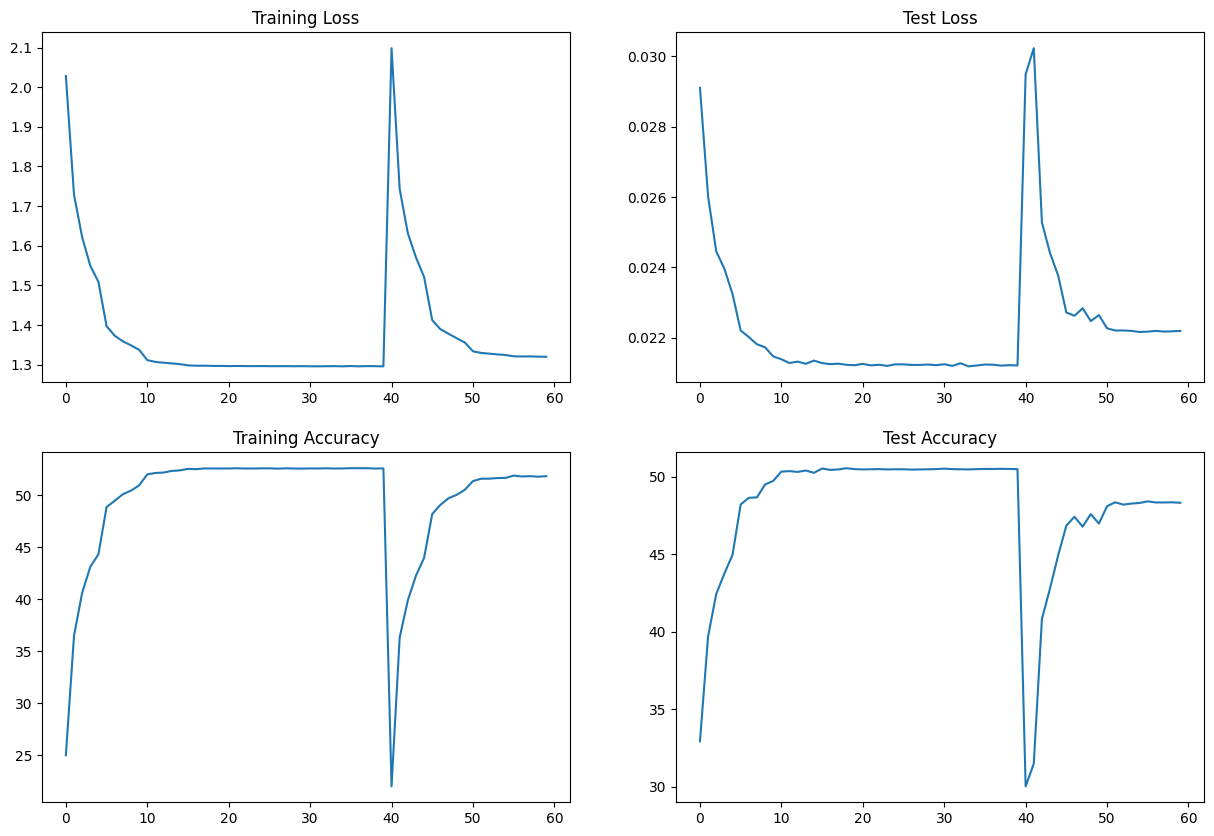

In [13]:
plot_acc_loss()

In [18]:
optimizer_adam = optim.Adam(model.parameters(), lr=1e-4,weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer_adam, step_size=5, gamma=0.1, verbose=True)
criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer_adam,criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()




Epoch 1


Train: Loss=1.6626 Batch_id=781 Accuracy=51.60: 100%|██████████| 782/782 [00:27<00:00, 28.35it/s]


Test set: Average loss: 0.0220, Accuracy: 4842/10000 (48.42%)

Epoch 2


Train: Loss=0.8420 Batch_id=781 Accuracy=52.01: 100%|██████████| 782/782 [00:31<00:00, 24.90it/s]


Test set: Average loss: 0.0221, Accuracy: 4823/10000 (48.23%)

Epoch 3


Train: Loss=1.6133 Batch_id=781 Accuracy=52.14: 100%|██████████| 782/782 [00:37<00:00, 20.91it/s]


Test set: Average loss: 0.0220, Accuracy: 4826/10000 (48.26%)

Epoch 4


Train: Loss=1.9657 Batch_id=781 Accuracy=52.48: 100%|██████████| 782/782 [00:38<00:00, 20.55it/s]


Test set: Average loss: 0.0220, Accuracy: 4847/10000 (48.47%)

Epoch 5


Train: Loss=1.2296 Batch_id=781 Accuracy=52.98: 100%|██████████| 782/782 [00:37<00:00, 20.94it/s]


Test set: Average loss: 0.0221, Accuracy: 4839/10000 (48.39%)

Epoch 6


Train: Loss=1.0314 Batch_id=781 Accuracy=53.53: 100%|██████████| 782/782 [00:35<00:00, 21.78it/s]


Test set: Average loss: 0.0217, Accuracy: 4889/10000 (48.89%)

Epoch 7


Train: Loss=1.3980 Batch_id=781 Accuracy=53.65: 100%|██████████| 782/782 [00:37<00:00, 20.60it/s]


Test set: Average loss: 0.0217, Accuracy: 4900/10000 (49.00%)

Epoch 8


Train: Loss=1.2717 Batch_id=781 Accuracy=53.72: 100%|██████████| 782/782 [00:41<00:00, 18.73it/s]


Test set: Average loss: 0.0217, Accuracy: 4912/10000 (49.12%)

Epoch 9


Train: Loss=1.1372 Batch_id=781 Accuracy=53.75: 100%|██████████| 782/782 [00:39<00:00, 19.65it/s]


Test set: Average loss: 0.0217, Accuracy: 4934/10000 (49.34%)

Epoch 10


Train: Loss=0.8732 Batch_id=781 Accuracy=53.83: 100%|██████████| 782/782 [00:42<00:00, 18.47it/s]


Test set: Average loss: 0.0216, Accuracy: 4931/10000 (49.31%)

Epoch 11


Train: Loss=1.1146 Batch_id=781 Accuracy=53.88: 100%|██████████| 782/782 [00:43<00:00, 17.89it/s]


Test set: Average loss: 0.0216, Accuracy: 4930/10000 (49.30%)

Epoch 12


Train: Loss=1.2416 Batch_id=781 Accuracy=53.96: 100%|██████████| 782/782 [00:42<00:00, 18.29it/s]


Test set: Average loss: 0.0217, Accuracy: 4924/10000 (49.24%)

Epoch 13


Train: Loss=1.1243 Batch_id=781 Accuracy=53.97: 100%|██████████| 782/782 [00:44<00:00, 17.43it/s]


Test set: Average loss: 0.0216, Accuracy: 4934/10000 (49.34%)

Epoch 14


Train: Loss=0.7902 Batch_id=781 Accuracy=53.97: 100%|██████████| 782/782 [00:44<00:00, 17.52it/s]


Test set: Average loss: 0.0217, Accuracy: 4928/10000 (49.28%)

Epoch 15


Train: Loss=1.2843 Batch_id=781 Accuracy=54.00: 100%|██████████| 782/782 [00:45<00:00, 17.05it/s]


Test set: Average loss: 0.0216, Accuracy: 4931/10000 (49.31%)

Epoch 16


Train: Loss=0.9357 Batch_id=781 Accuracy=53.96: 100%|██████████| 782/782 [00:45<00:00, 17.02it/s]


Test set: Average loss: 0.0217, Accuracy: 4931/10000 (49.31%)

Epoch 17


Train: Loss=1.4655 Batch_id=781 Accuracy=53.98: 100%|██████████| 782/782 [00:37<00:00, 20.87it/s]


Test set: Average loss: 0.0217, Accuracy: 4931/10000 (49.31%)

Epoch 18


Train: Loss=1.6021 Batch_id=781 Accuracy=53.96: 100%|██████████| 782/782 [00:37<00:00, 20.98it/s]


Test set: Average loss: 0.0217, Accuracy: 4931/10000 (49.31%)

Epoch 19


Train: Loss=1.2212 Batch_id=781 Accuracy=53.96: 100%|██████████| 782/782 [00:37<00:00, 21.03it/s]


Test set: Average loss: 0.0217, Accuracy: 4932/10000 (49.32%)

Epoch 20


Train: Loss=1.5112 Batch_id=781 Accuracy=53.96: 100%|██████████| 782/782 [00:19<00:00, 40.13it/s]


Test set: Average loss: 0.0216, Accuracy: 4932/10000 (49.32%)



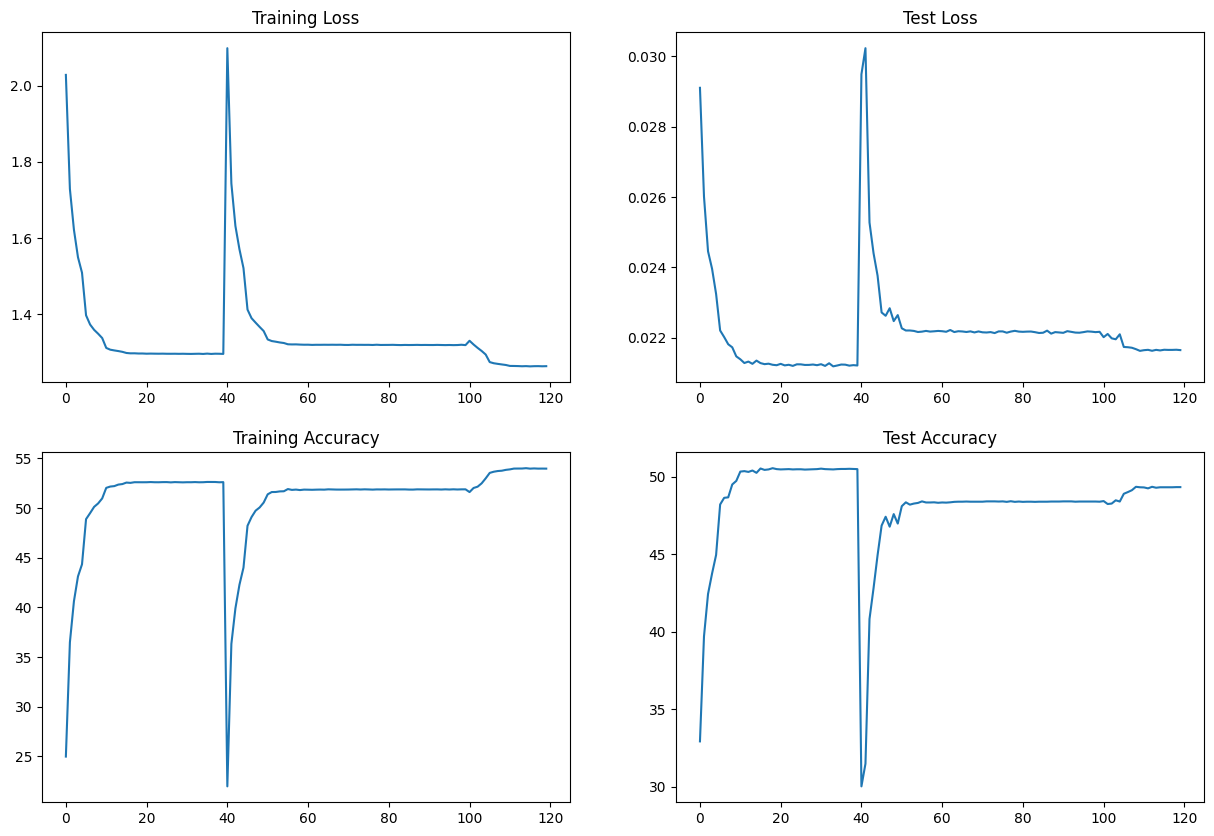

In [19]:
plot_acc_loss()